In [14]:
# Install libraries you don't have 
import sys
!{sys.executable} -m pip install Pillow pandas scikit-learn joblib cv 

In [30]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In [23]:
data = []
labels = []
class_size = 43

for file in range(class_size) :
    path = "./Dataset/Train/{0}/".format(file)
    Class = os.listdir(path)
    for c in Class:
        try:
            image = cv2.imread(path + c)
            image_from_array = Image.fromarray(image, 'RGB')
            resized_image = image_from_array.resize((30, 30))
            resized_images = np.array(resized_image)
            data.append(resized_images)
            labels.append(file)
        except AttributeError:
            print(" ")

In [24]:
Images=np.array(data)
labels=np.array(labels)

In [25]:
# Shuffling the data 
value = np.arange(Images.shape[0])
np.random.seed(class_size)
np.random.shuffle(value)
Images = Images[value]
labels = labels[value]
image_data = len(Images)
labels_data = len(labels)

Training:  (31368, 30, 30, 3)
Testing : (7841, 30, 30, 3)


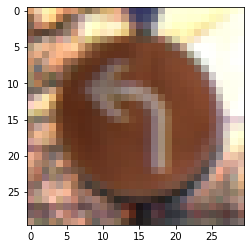

In [39]:
# Spliting the images into train and validation sets 
(training_images, validation_images) = Images[(int)(0.2 * labels_data):], Images[:(int)(0.2 * labels_data)]
training_images = training_images.astype('float32') / 255 
validation_images = validation_images.astype('float32') / 255
(training_labels, validation_labels) = labels[(int)(0.2 * labels_data):], labels[:(int)(0.2 * labels_data)]
print("Training: ", training_images.shape)
print("Testing :", validation_images.shape)
plt.imshow(training_images[0])
plt.show()


In [28]:
# Using one hot encoding for the labels
from keras.utils import to_categorical
training_labels = to_categorical(training_labels, class_size)
validation_labels = to_categorical(validation_labels, class_size)

In [40]:
# Define a Callback class that stops training once accuracy reaches 97%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# DNN Model 
